In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import pickle

with open("/content/drive/MyDrive/20241/patrones/proyecto/DATA_seconds_bal_xy_tt_ol.pkl", "rb") as f:
    x_train, x_test, y_train, y_test, classes = pickle.load(f)

In [ ]:
import numpy as np
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [ ]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='local')
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

All devices:  [LogicalDevice(name='/device:TPU:0', device_type='TPU'), LogicalDevice(name='/device:TPU:1', device_type='TPU'), LogicalDevice(name='/device:TPU:2', device_type='TPU'), LogicalDevice(name='/device:TPU:3', device_type='TPU'), LogicalDevice(name='/device:TPU:4', device_type='TPU'), LogicalDevice(name='/device:TPU:5', device_type='TPU'), LogicalDevice(name='/device:TPU:6', device_type='TPU'), LogicalDevice(name='/device:TPU:7', device_type='TPU')]


In [ ]:
import matplotlib.pyplot as plt
def plotaccloss(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(14, 6))

    # Plotting training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'bo-', label='Training loss')
    plt.plot(epochs, val_loss, 'r*-', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plotting training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, 'bo-', label='Training accuracy')
    plt.plot(epochs, val_accuracy, 'r*-', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
from sklearn.preprocessing import StandardScaler

# Standardize the input data
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.fit_transform(x_test)

In [ ]:
nout=len(classes)

In [ ]:
from keras.models import Sequential
from keras.layers import Input,Dense, LSTM, Bidirectional, Reshape, GRU,Dropout,BatchNormalization

strategy = tf.distribute.TPUStrategy(resolver)

# Define the model inside the strategy scope
with strategy.scope():
    model = Sequential()
    model.add(Input(shape=(15360,)))
    model.add(Reshape((30, 512)))

    # LSTM layer
    model.add(LSTM(256))

    # Dense layer
    model.add(Dense(32, activation='relu', kernel_regularizer='l1'))
    model.add(Dropout(0.2))

    model.add(Dense(nout, activation='softmax'))

    if nout == 2:
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    else:
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


# Summarize the model
# model.summary()

Epoch 1/100
474/474 [==============================] - 16s 24ms/step - loss: 2.0749 - accuracy: 0.2952 - val_loss: 1.3998 - val_accuracy: 0.3092
Epoch 2/100
474/474 [==============================] - 7s 15ms/step - loss: 1.4060 - accuracy: 0.3069 - val_loss: 1.4013 - val_accuracy: 0.3058
Epoch 3/100
474/474 [==============================] - 7s 15ms/step - loss: 1.3879 - accuracy: 0.3351 - val_loss: 1.3986 - val_accuracy: 0.3187
Epoch 4/100
474/474 [==============================] - 7s 16ms/step - loss: 1.3664 - accuracy: 0.3607 - val_loss: 1.3568 - val_accuracy: 0.3567
Epoch 5/100
474/474 [==============================] - 7s 16ms/step - loss: 1.3491 - accuracy: 0.3739 - val_loss: 1.3549 - val_accuracy: 0.3681
Epoch 6/100
474/474 [==============================] - 7s 16ms/step - loss: 1.3328 - accuracy: 0.3773 - val_loss: 1.3488 - val_accuracy: 0.3646
Epoch 7/100
474/474 [==============================] - 7s 15ms/step - loss: 1.3103 - accuracy: 0.4021 - val_loss: 1.3579 - val_accuracy

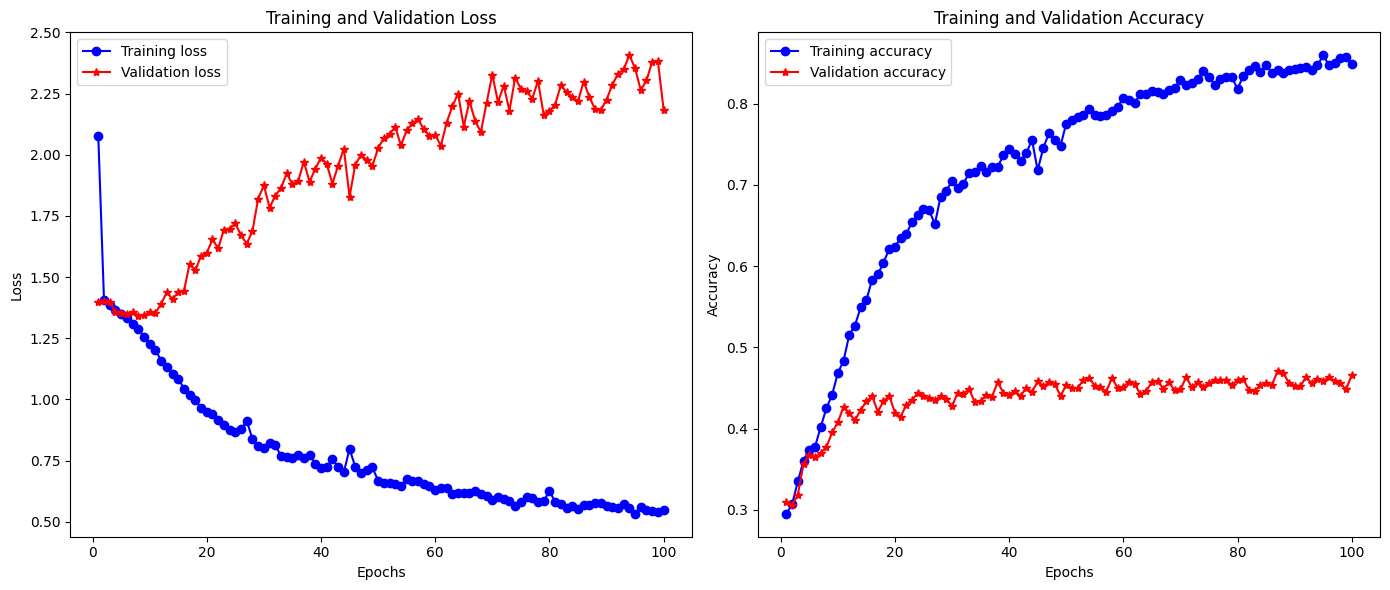

In [ ]:
# Train the model
history = model.fit(x_train_scaled, y_train, epochs=100, batch_size=32, validation_split=0.2)
plotaccloss(history)

In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(x_test_scaled, y_test)
print(f'Test Accuracy: {accuracy:.4f}')

149/149 [==============================] - 2s 9ms/step - loss: 2.2110 - accuracy: 0.4600
Test Accuracy: 0.4600


In [ ]:
y_pred_prob = model.predict(x_test_scaled)
y_pred = np.argmax(y_pred_prob, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

149/149 [==============================] - 2s 9ms/step


<Figure size 1000x800 with 0 Axes>

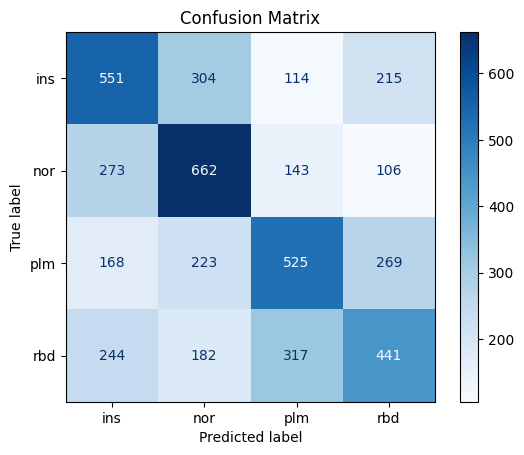

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test_labels, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()